In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
#from skimage import io



In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
annotations_file = 'annotations_imSize.csv'

In [4]:
anno = pd.read_csv(annotations_file)
anno.head()

,filename,x1,y1,x2,y2,class,Train/Test,width,height
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480


In [5]:
minValue = anno[['width', 'height']].min()
print(minValue)

maxValue = anno[['width', 'height']].max()
print(maxValue)

width     640
height    480
dtype: int64
width     704
height    480
dtype: int64


In [6]:
anno.value_counts("width")

width
704    673
640    227
dtype: int64

In [7]:
anno.value_counts("height")

height
480    900
dtype: int64

In [8]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [9]:
# # Code for plotting bounding box
# def plot_bbox(img_id):
#   img_url = img_id
#   img = io.imread(img_url)
#   height, width, channel = img.shape
#   print(f"Image: {img.shape}")
#   bboxs = anno[anno['filename']==img_id]
#   for index, row in bboxs.iterrows():
#       xmin = row['x1']
#       xmax = row['x2']
#       ymin = row['y1']
#       ymax = row['y2']
#       label_name = row['class']
#       print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
#       cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
#       font = cv2.FONT_HERSHEY_SIMPLEX
#       cv2.putText(img, label_name, (xmin,ymin-10), font, 1, (0,255,0), 2)
#   plt.figure(figsize=(15,10))
#   plt.title('Image with Bounding Box')
#   plt.imshow(img)
#   plt.axis("off")
#   plt.show()

In [10]:
# sz = 300

# im = read_image("db_lisa_tiny/sample_001.png")
# im_resized = cv2.resize(im, (int(1.49*sz), sz))

# Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))



In [11]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [12]:
def create_bb_array(x):
    """Generates bounding box array from a anno row"""
    return np.array([x[2],x[1],x[4],x[3]])

In [13]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = r'{}/{}'.format(write_path,read_path)
    print(new_path)
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [14]:
anno.loc[0].values

array(['db_lisa_tiny/sample_001.png', 190, 40, 211, 63, 'stop', 'Train',
       704, 480], dtype=object)

In [15]:
a = anno.loc[0].values
b = create_bb_array(a)

c, d = resize_image_bb('db_lisa_tiny/sample_001.png',"lisa_resize/abc.jpg",b , 300)

c
d

lisa_resize/abc.jpg/db_lisa_tiny/sample_001.png


array([ 25., 120.,  39., 133.], dtype=float32)

In [16]:
train_path_resized = Path('lisa_resize')
print(type(train_path_resized))

<class 'pathlib.PosixPath'>


In [17]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = 'lisa_resize'
for index, row in anno.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
anno['new_path'] = new_paths
anno['new_bb'] = new_bbs

lisa_resize/db_lisa_tiny/sample_401.png
lisa_resize/db_lisa_tiny/sample_402.png
lisa_resize/db_lisa_tiny/sample_403.png
lisa_resize/db_lisa_tiny/sample_404.png
lisa_resize/db_lisa_tiny/sample_405.png
lisa_resize/db_lisa_tiny/sample_406.png
lisa_resize/db_lisa_tiny/sample_407.png
lisa_resize/db_lisa_tiny/sample_408.png
lisa_resize/db_lisa_tiny/sample_409.png
lisa_resize/db_lisa_tiny/sample_410.png
lisa_resize/db_lisa_tiny/sample_411.png
lisa_resize/db_lisa_tiny/sample_412.png
lisa_resize/db_lisa_tiny/sample_413.png
lisa_resize/db_lisa_tiny/sample_414.png
lisa_resize/db_lisa_tiny/sample_415.png
lisa_resize/db_lisa_tiny/sample_416.png
lisa_resize/db_lisa_tiny/sample_417.png
lisa_resize/db_lisa_tiny/sample_418.png
lisa_resize/db_lisa_tiny/sample_419.png
lisa_resize/db_lisa_tiny/sample_420.png
lisa_resize/db_lisa_tiny/sample_421.png
lisa_resize/db_lisa_tiny/sample_422.png
lisa_resize/db_lisa_tiny/sample_423.png
lisa_resize/db_lisa_tiny/sample_424.png
lisa_resize/db_lisa_tiny/sample_425.png


In [18]:
anno

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]"
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]"
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]"
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]"
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]"
...,...,...,...,...,...,...,...,...,...,...,...
895,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_896.png,"[97.0, 339.0, 116.0, 357.0]"
896,db_lisa_tiny/sample_897.png,526,223,540,240,speedLimit25,Train,640,480,lisa_resize/db_lisa_tiny/sample_897.png,"[139.0, 367.0, 149.0, 377.0]"
897,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_898.png,"[147.0, 402.0, 167.0, 420.0]"
898,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_899.png,"[170.0, 258.0, 187.0, 273.0]"


In [19]:
width_list = []
height_list = []

for i in anno["new_path"]:
    image = Image.open(i)

    width, height = image.size
    
    width_list.append(width)
    height_list.append(height)

# Insert width and height of images to annotations data frame
anno['new_width'] = width_list
anno['new_height'] = height_list

anno.head()

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb,new_width,new_height
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]",447,300
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]",447,300
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]",447,300
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]",447,300
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]",447,300


In [20]:
anno.value_counts("new_width")

new_width
447    900
dtype: int64

In [21]:
anno.value_counts("new_height")

new_height
300    900
dtype: int64

In [22]:
im = cv2.imread("db_lisa_tiny/sample_001.png")
bb = create_bb_array(anno.values[0])
print(im.shape)

(480, 704, 3)


In [23]:
Y = create_mask(bb, im)
mask_to_bb(Y)


array([ 40., 190.,  62., 210.], dtype=float32)

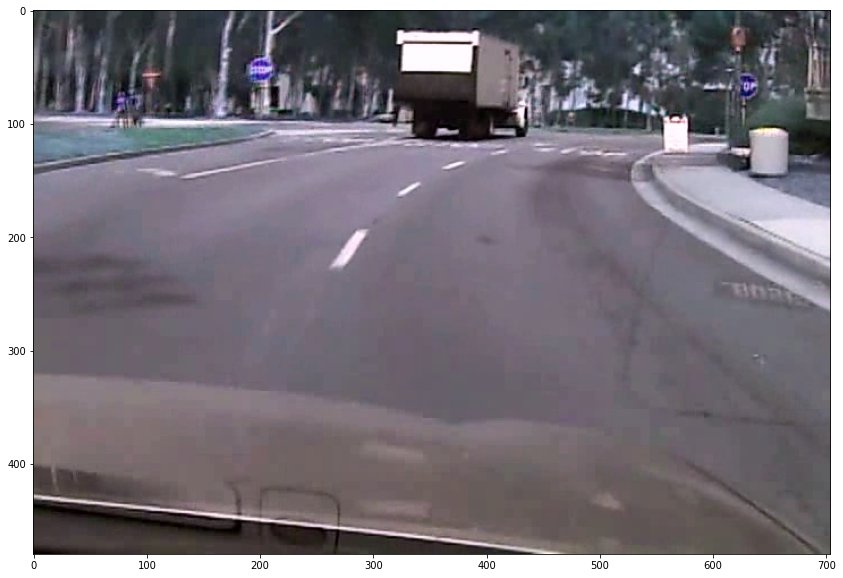

In [24]:
plt.figure(figsize=(15,10))
plt.imshow(im)

In [25]:
#plot_bbox("db_lisa_tiny/sample_001.png")

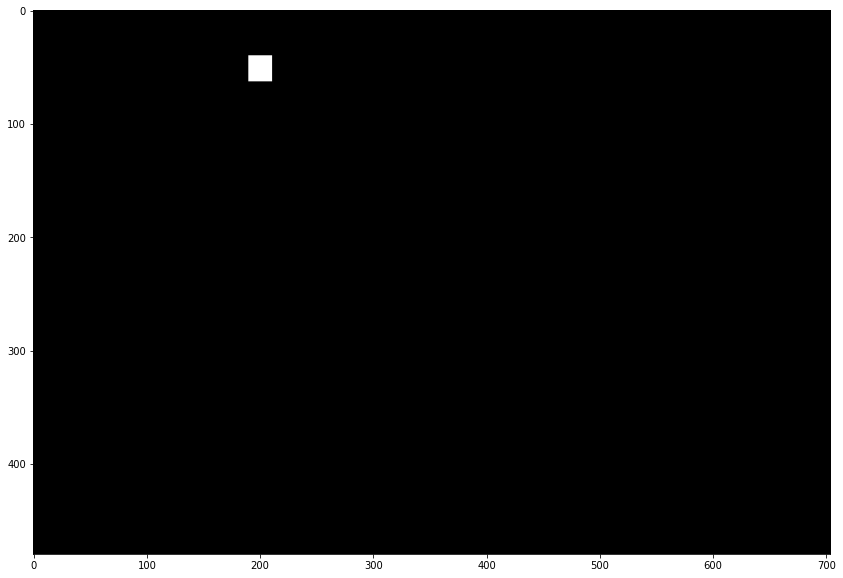

In [26]:
plt.figure(figsize=(15,10))
plt.imshow(Y, cmap='gray')


In [27]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [28]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [29]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.figure(figsize=(15,10))
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

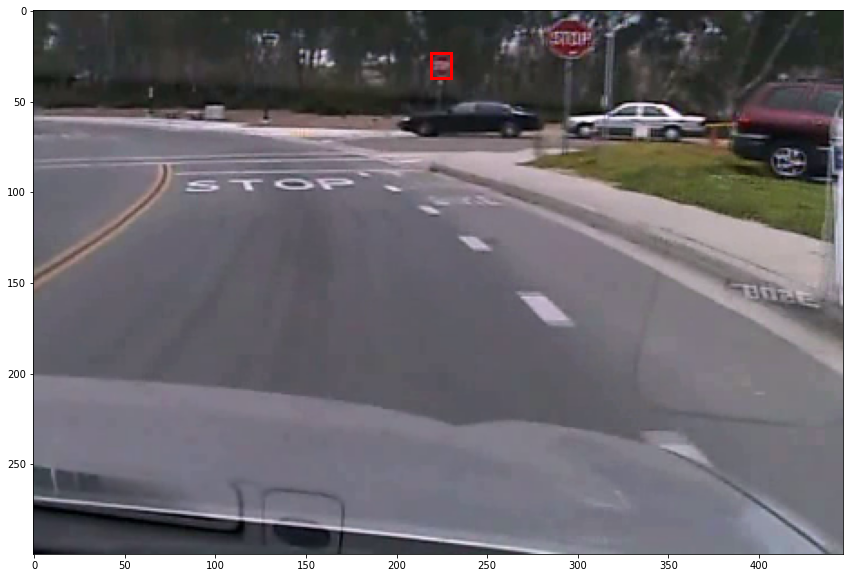

In [30]:
im_num = random.randint(0, 900)
im = cv2.imread(str(anno.values[im_num][9]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, anno.values[im_num][10])

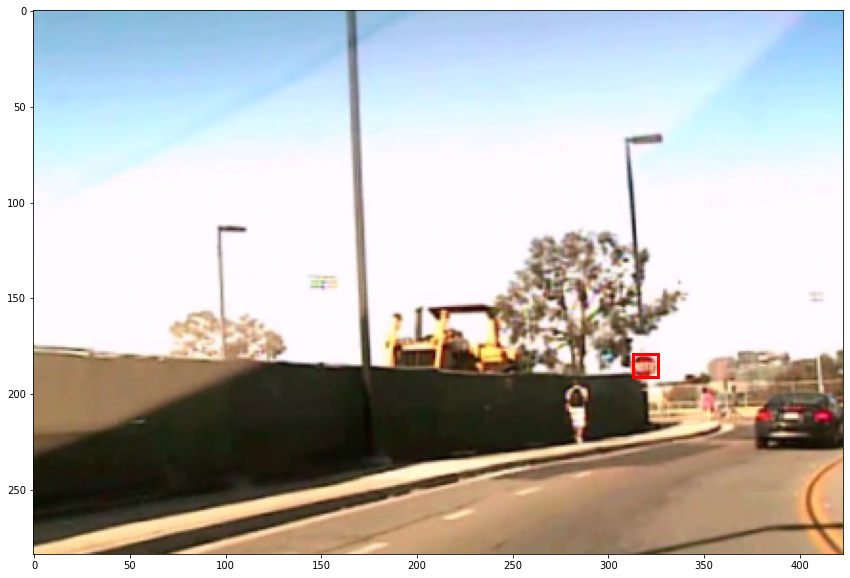

In [31]:
im, bb = transformsXY(str(anno.values[68][9]),anno.values[68][10],True )
show_corner_bb(im, bb)

In [32]:
anno.value_counts("class")

class
stop                  210
speedLimit35          110
keepRight             110
signalAhead           100
pedestrianCrossing    100
merge                 100
speedLimit25           80
yieldAhead             45
yield                  45
dtype: int64

In [33]:
unique = anno["class"].unique()
unique

array(['stop', 'yield', 'yieldAhead', 'merge', 'signalAhead',
       'pedestrianCrossing', 'keepRight', 'speedLimit35', 'speedLimit25'],
      dtype=object)

In [34]:
#Convert classes to dict and reverse key value pair
unique_enum = enumerate(unique)
unique_enum = dict(unique_enum)
unique_enum = {v: k for k, v in unique_enum.items()}
unique_enum

{'stop': 0,
 'yield': 1,
 'yieldAhead': 2,
 'merge': 3,
 'signalAhead': 4,
 'pedestrianCrossing': 5,
 'keepRight': 6,
 'speedLimit35': 7,
 'speedLimit25': 8}

In [35]:
# Create a column named Class Index
class_idx = []
for rows in anno["class"]:
    class_idx.append(unique_enum[rows])

anno["class_idx"] = class_idx

anno
    

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb,new_width,new_height,class_idx
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]",447,300,0
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]",447,300,0
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]",447,300,0
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]",447,300,0
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]",447,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_896.png,"[97.0, 339.0, 116.0, 357.0]",447,300,8
896,db_lisa_tiny/sample_897.png,526,223,540,240,speedLimit25,Train,640,480,lisa_resize/db_lisa_tiny/sample_897.png,"[139.0, 367.0, 149.0, 377.0]",447,300,8
897,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_898.png,"[147.0, 402.0, 167.0, 420.0]",447,300,8
898,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_899.png,"[170.0, 258.0, 187.0, 273.0]",447,300,8


In [36]:
df_train = anno.reset_index()

In [37]:
df_train

,index,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb,new_width,new_height,class_idx
0,0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]",447,300,0
1,1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]",447,300,0
2,2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]",447,300,0
3,3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]",447,300,0
4,4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]",447,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_896.png,"[97.0, 339.0, 116.0, 357.0]",447,300,8
896,896,db_lisa_tiny/sample_897.png,526,223,540,240,speedLimit25,Train,640,480,lisa_resize/db_lisa_tiny/sample_897.png,"[139.0, 367.0, 149.0, 377.0]",447,300,8
897,897,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_898.png,"[147.0, 402.0, 167.0, 420.0]",447,300,8
898,898,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_899.png,"[170.0, 258.0, 187.0, 273.0]",447,300,8


In [38]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class_idx']

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [40]:
y_train

10     0
334    3
244    1
678    6
306    3
      ..
106    0
270    2
860    8
435    4
102    0
Name: class_idx, Length: 720, dtype: int64

In [41]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [42]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [43]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
batch_size = 4
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=0)

In [46]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [47]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr
        

In [48]:
a = torch.tensor([1, 2, 3, 4])


In [49]:
def train_epocs(model, optimizer, train_dl,epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [50]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [51]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [52]:
train_epocs(model, optimizer, train_dl, 15)

RuntimeError: CUDA error: device-side assert triggered

In [53]:

torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered

In [54]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  392022 KB |  416593 KB |  632035 KB |  240013 KB |\n|       from large pool |  371721 KB |  398345 KB |  608096 KB |  236375 KB |\n|       from small pool |   20301 KB |   20302 KB |   23939 KB |    3638 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |  392022 KB |  416593 KB |  632035 KB |  240013 KB |\n|       from large pool |  371721 KB |  398345 KB |